# Evaluation

In [1]:
import os

from pathlib import Path

from IPython.display import display, Image

from video_intelligence.utils import io
from video_intelligence.processing.types import Detection
from video_intelligence.utils import ocv
from video_intelligence.evaluation.detections import ObjectDetectionEvaluator
from video_intelligence.config import Config

In [2]:
config_file = Path.cwd().parent / "config.yaml"
config = Config.from_yaml(config_file)

In [3]:
evaluator = ObjectDetectionEvaluator(
    config.paths.ground_truth,
    config.paths.results
)

eval = evaluator.run_evaluation()
ObjectDetectionEvaluator.display_results(eval)

Parsing ground truth...
Parsing predictions...
Calculating metrics...

OBJECT DETECTION EVALUATION RESULTS (11-Point Interpolation)

Configuration:
  IoU Threshold: 0.3

PER-CLASS METRICS:
-------------------------------------------------------------------------------------
Label                AP         Precision  Recall     TP      FP      FN     
-------------------------------------------------------------------------------------
car                  0.5652     0.553     0.832     89      72      18     
human                0.6753     0.500     0.889     8       8       1      
traffic light        0.2386     0.256     0.564     22      64      17     
traffic sign         0.1947     0.176     0.520     13      61      12     
-------------------------------------------------------------------------------------

Mean Average Precision (mAP): 0.4185



In [4]:
gcs_io = io.GcsIO(config.project_id, f"gs://{config.bucket}")
local_io = io.LocalIO(root_path=config.paths.tmp)

In [5]:
videos = gcs_io.list_files(path=config.output_path, rec=True)

In [6]:
processed_videos = []
for _, gcs_path in enumerate(videos):
    video = gcs_io.get_video(path=gcs_path)
    path = gcs_path.split('/')[-1]
    local_io.save_video(video, path)
    processed_videos.append(os.path.join(config.paths.tmp, path))

In [7]:
with open(config.paths.ground_truth, "r") as f:
    import json
    gt = json.loads(f.read())
gt

{'preprocessed/00225f53-67614580/00225f53-67614580.mp4': [{'timestamp': '00:00',
   'objects': [{'box_2d': [493, 99, 944, 337],
     'label': 'car',
     'confidence': 1.0},
    {'box_2d': [610, 310, 808, 377], 'label': 'car', 'confidence': 1.0},
    {'box_2d': [545, 368, 710, 430], 'label': 'car', 'confidence': 1.0},
    {'box_2d': [584, 428, 795, 516], 'label': 'car', 'confidence': 1.0},
    {'box_2d': [587, 512, 707, 550], 'label': 'car', 'confidence': 1.0},
    {'box_2d': [600, 548, 658, 569], 'label': 'car', 'confidence': 1.0},
    {'box_2d': [551, 568, 788, 681], 'label': 'car', 'confidence': 1.0},
    {'box_2d': [581, 684, 788, 780], 'label': 'car', 'confidence': 1.0},
    {'box_2d': [642, 784, 808, 877], 'label': 'car', 'confidence': 1.0},
    {'box_2d': [639, 906, 879, 988], 'label': 'car', 'confidence': 1.0},
    {'box_2d': [366, 355, 480, 385],
     'label': 'traffic sign',
     'confidence': 1.0}]},
  {'timestamp': '00:01',
   'objects': [{'box_2d': [584, 10, 996, 215],
   

Video capture initialized.
Video properties: FPS=1.0, Width=1280, Height=480, Frames=8, Rotation=0


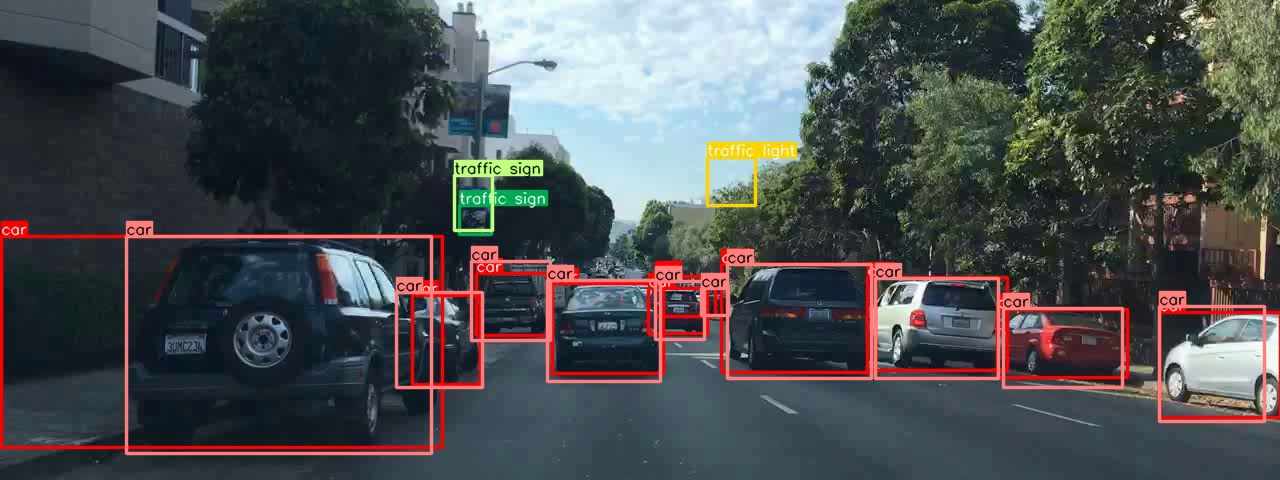

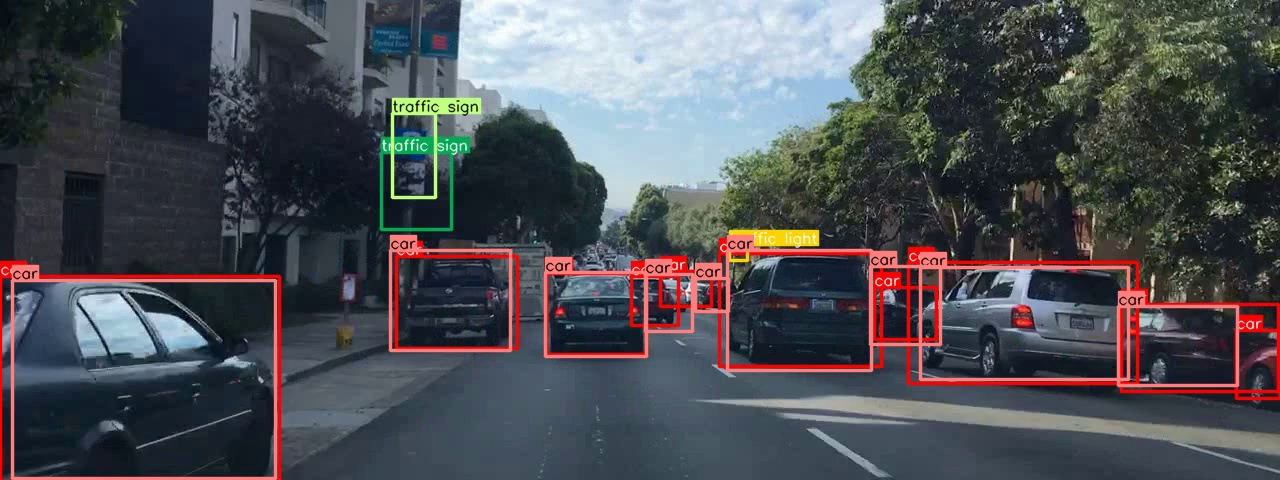

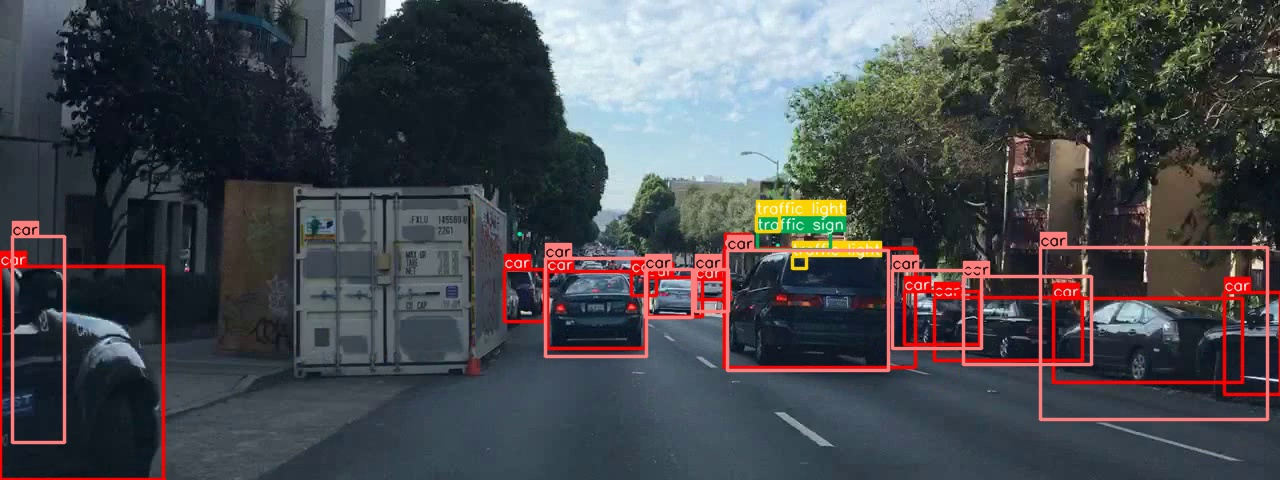

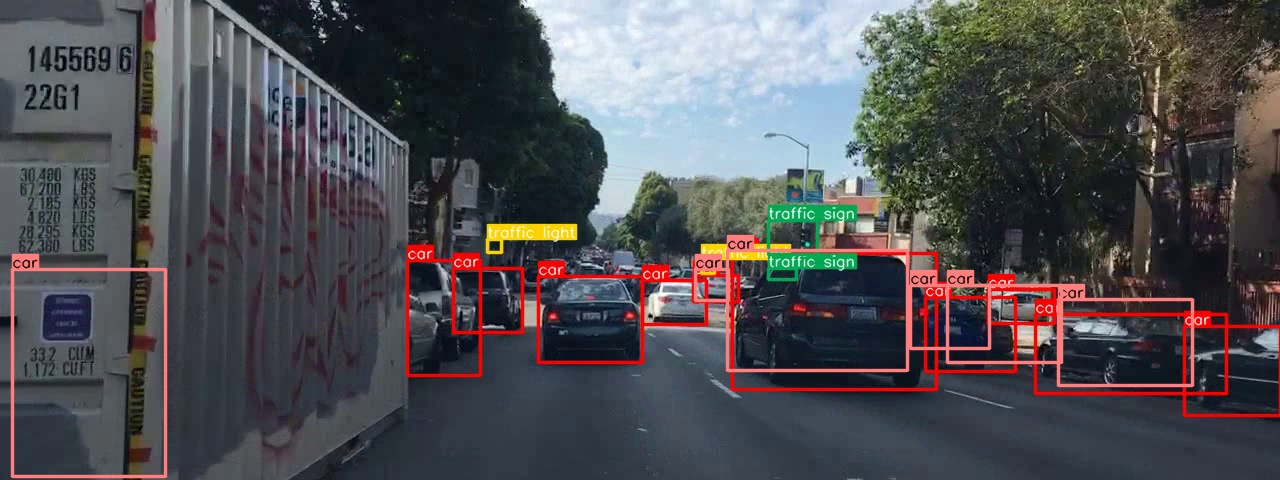

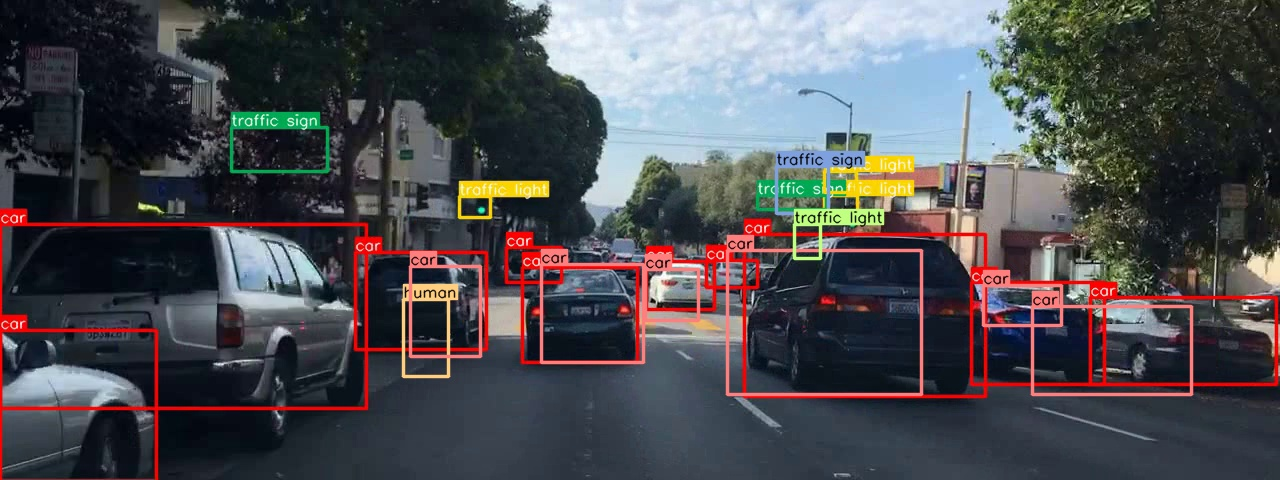

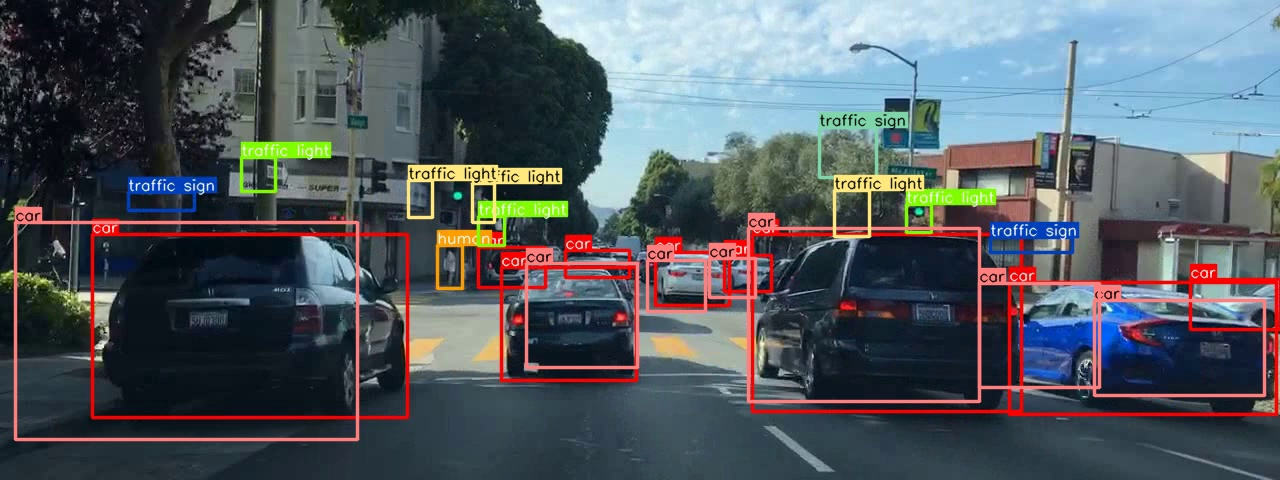

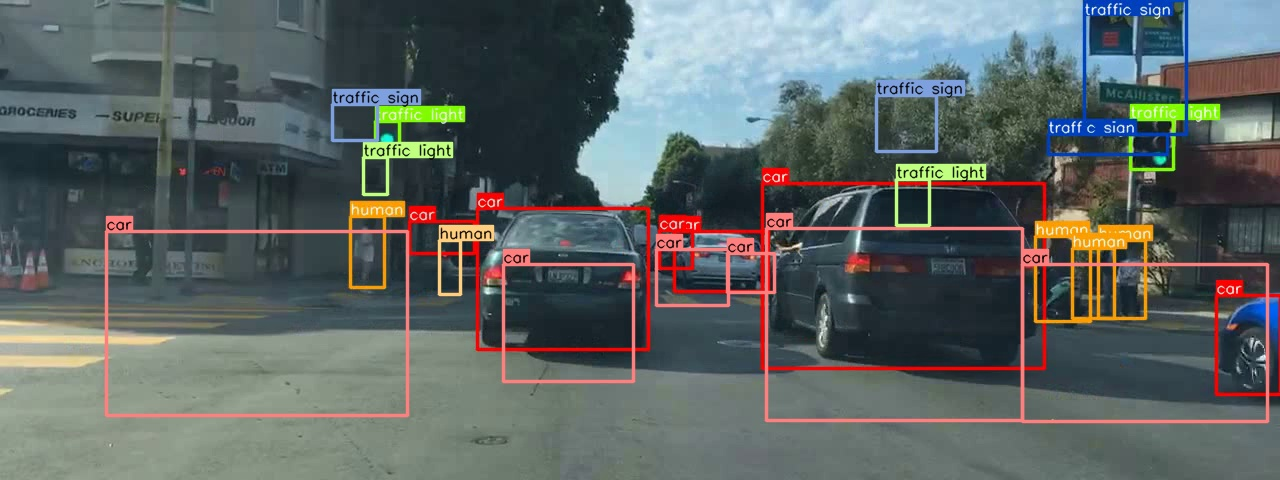

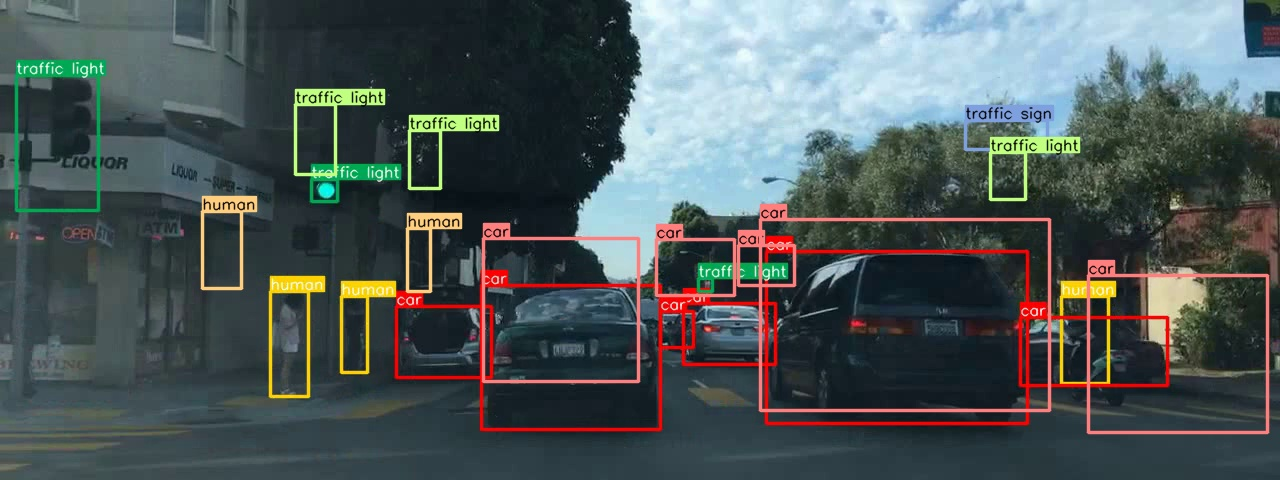

No more frames to read.
Finished processing 00225f53-67614580.mp4.
Video capture initialized.
Video properties: FPS=1.0, Width=1280, Height=480, Frames=9, Rotation=0


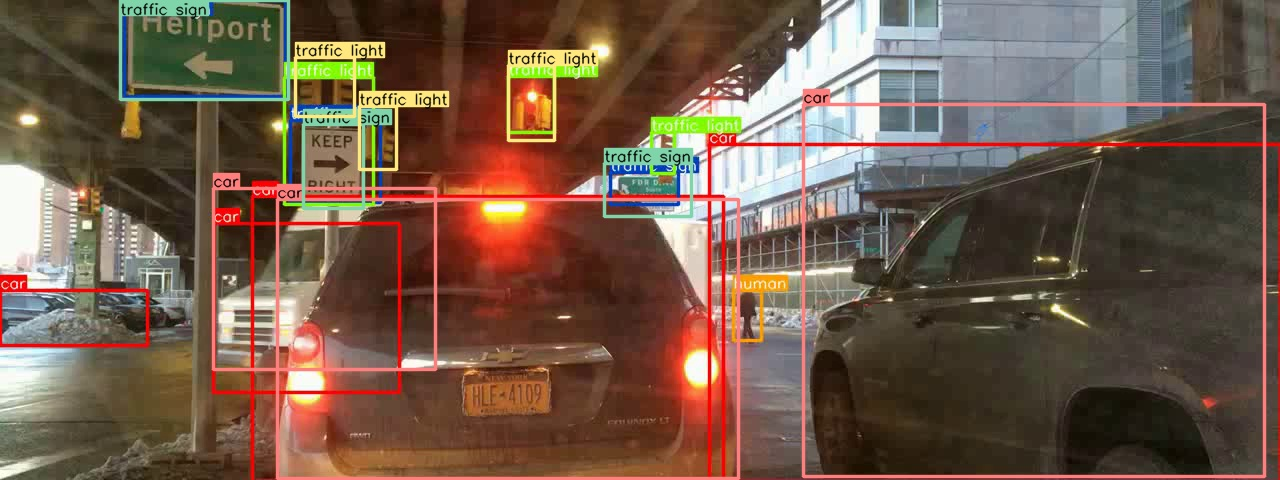

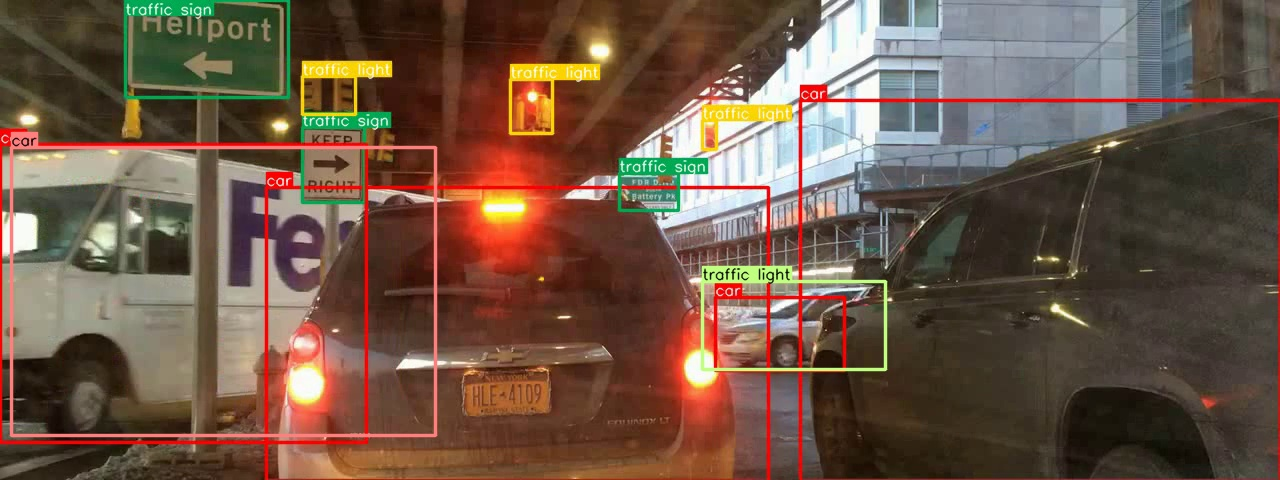

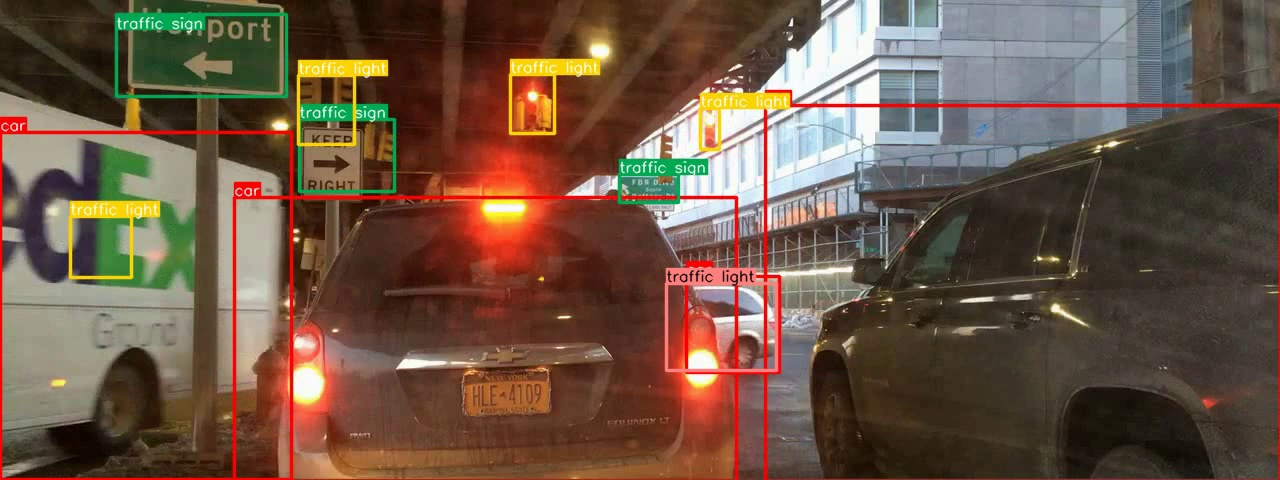

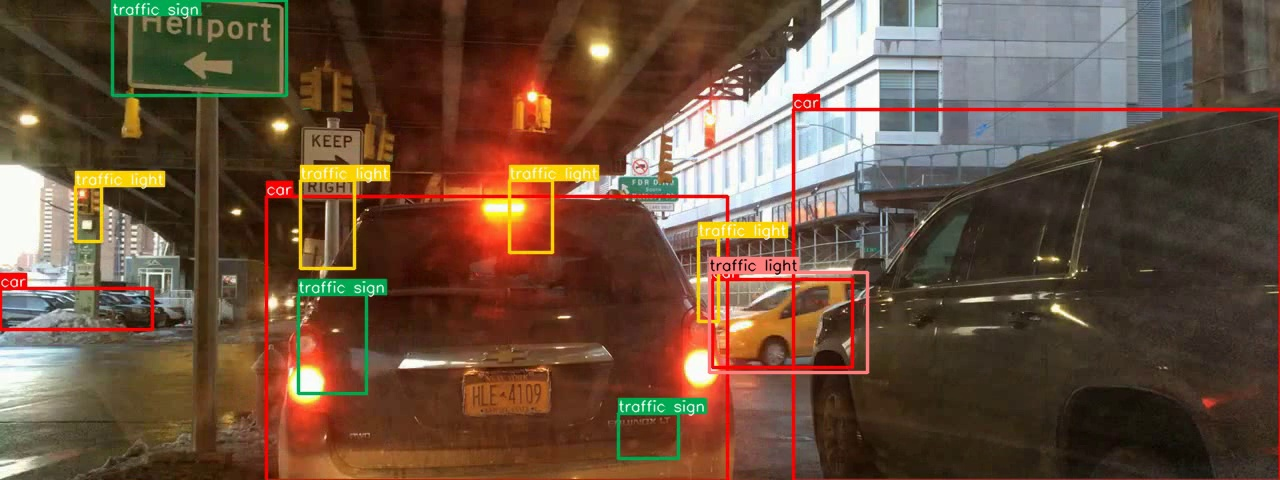

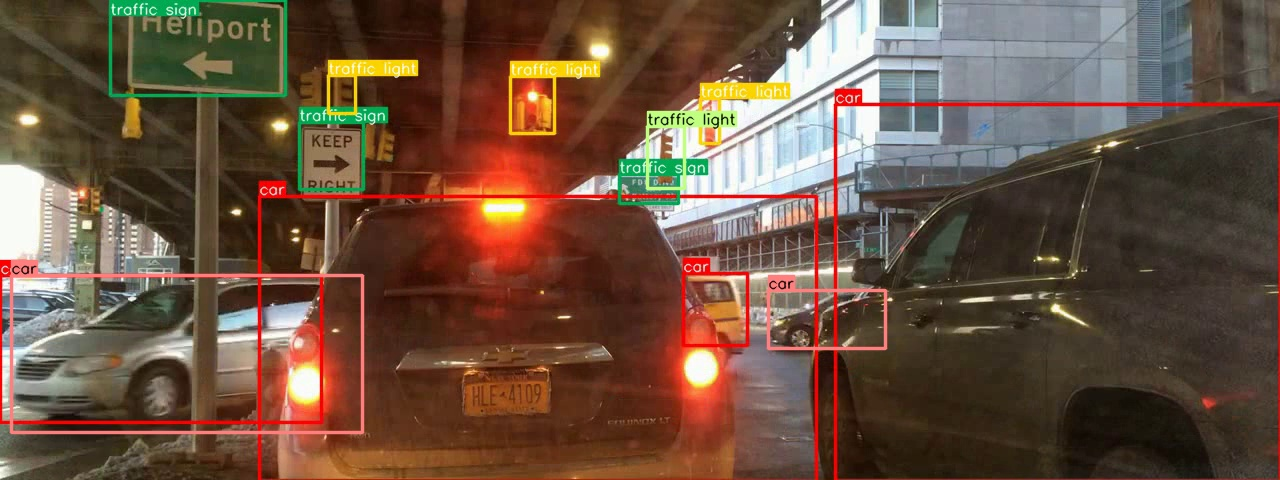

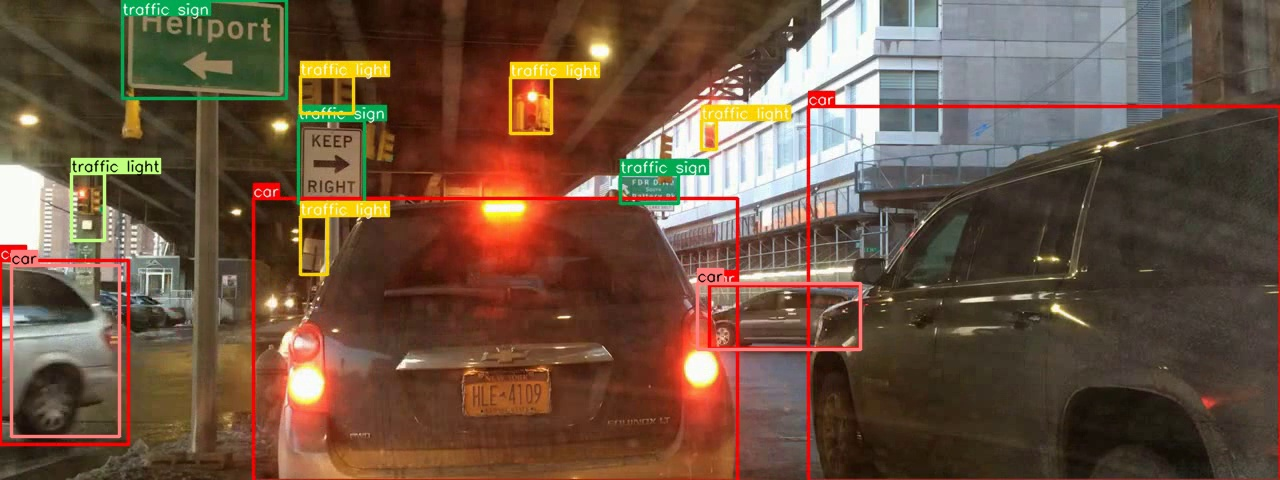

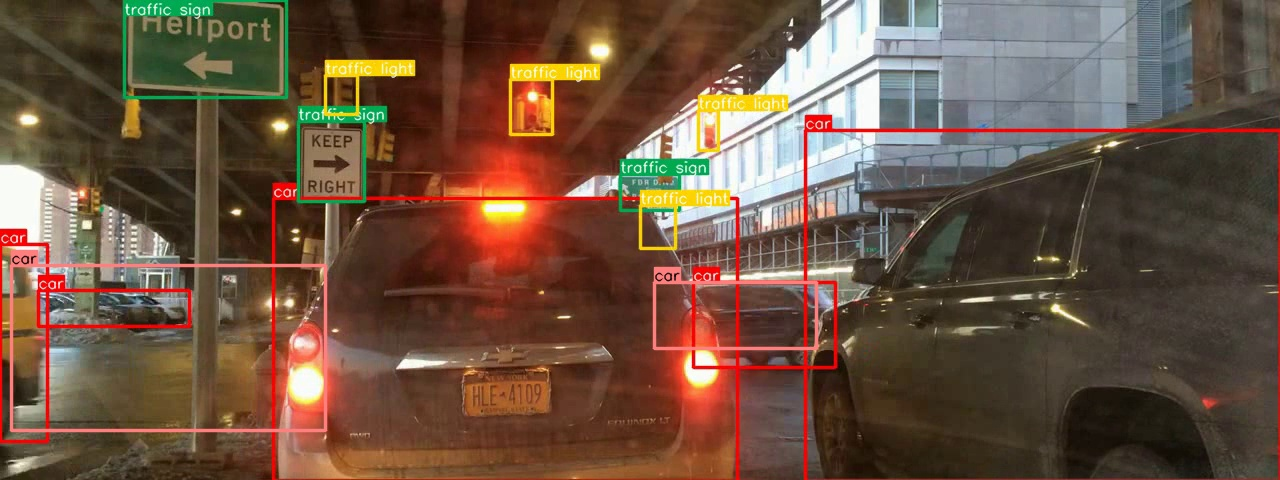

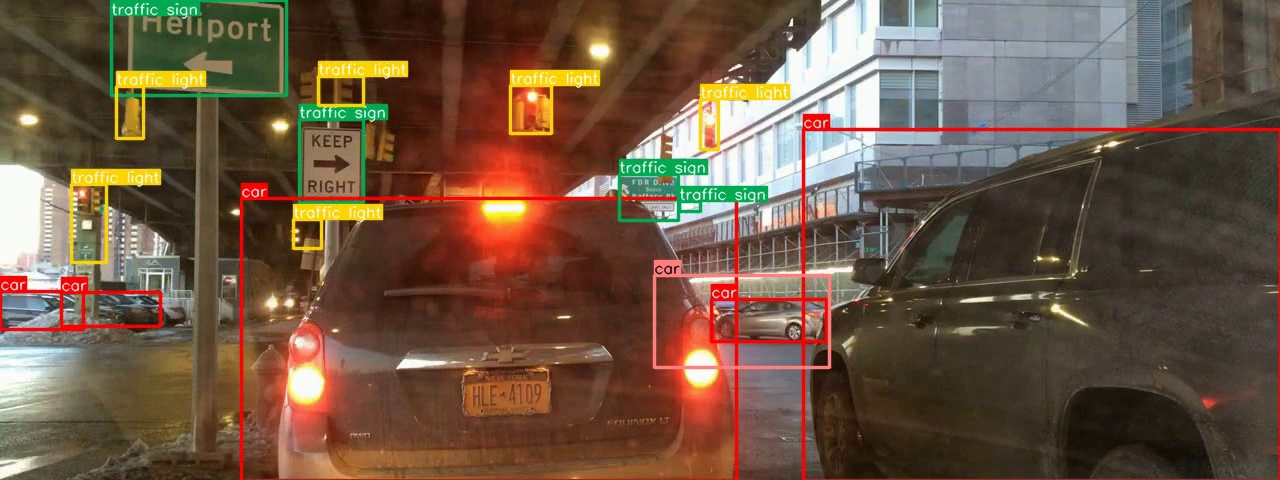

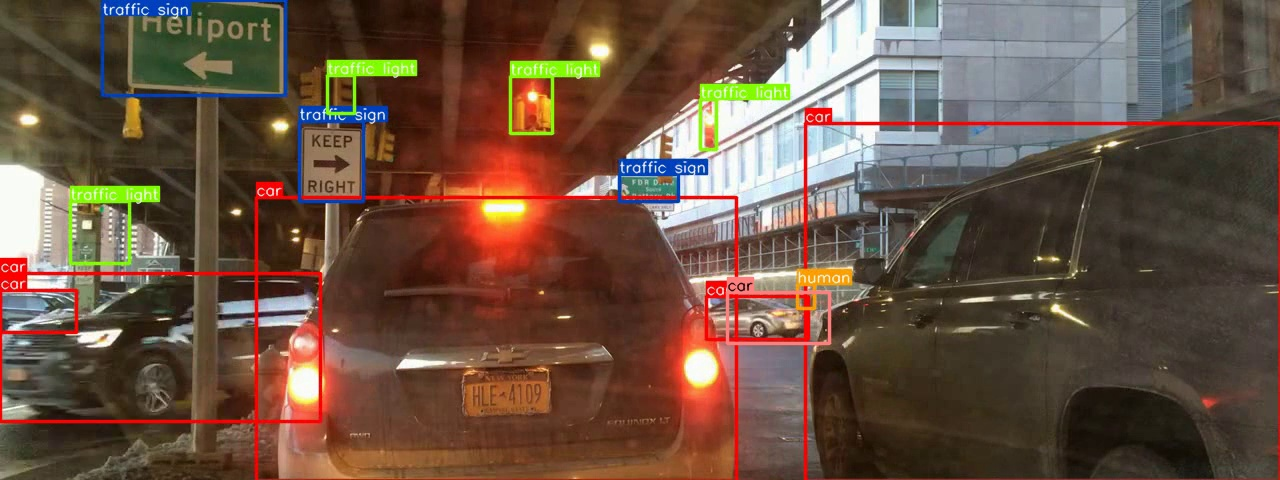

No more frames to read.
Finished processing 00091078-7cff8ea6.mp4.
Video capture initialized.
Video properties: FPS=1.0, Width=1280, Height=480, Frames=10, Rotation=0


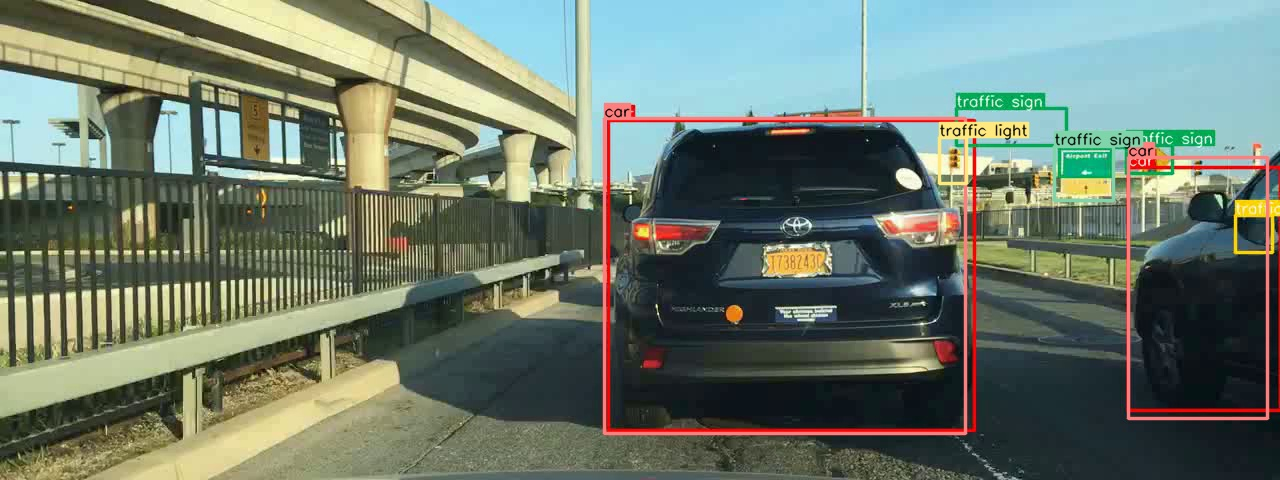

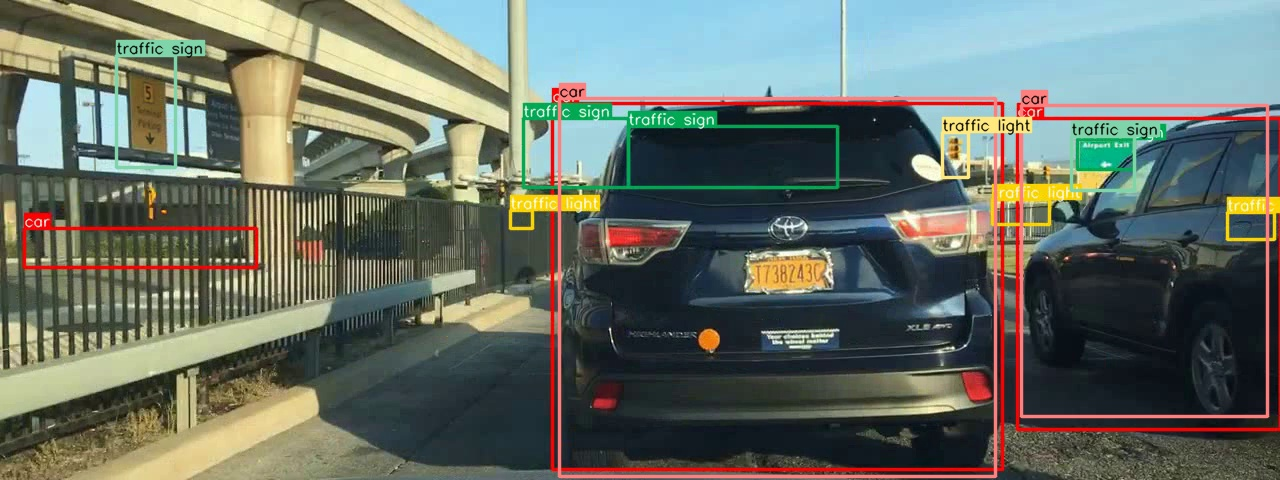

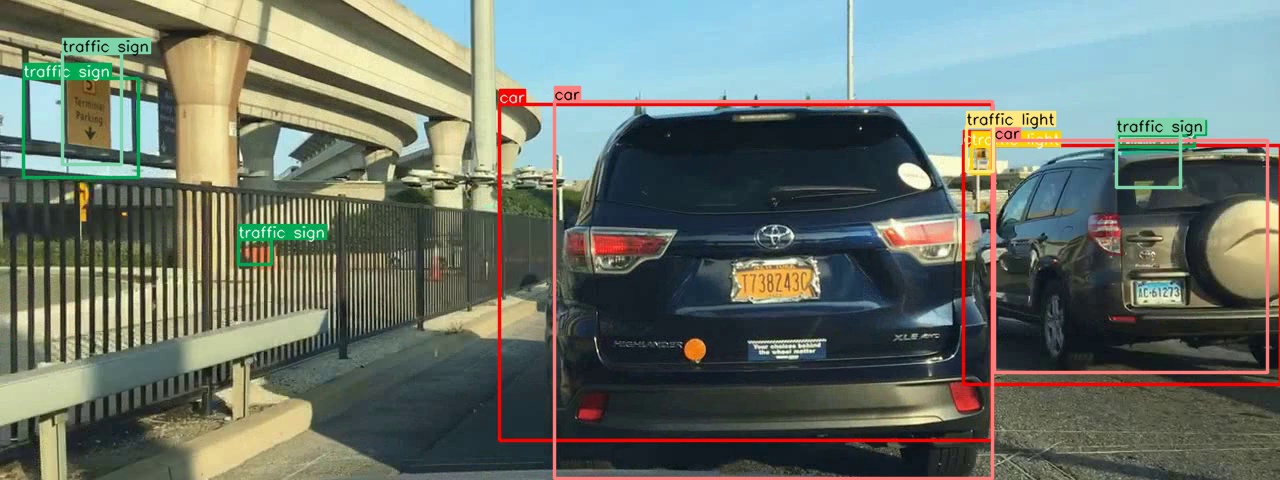

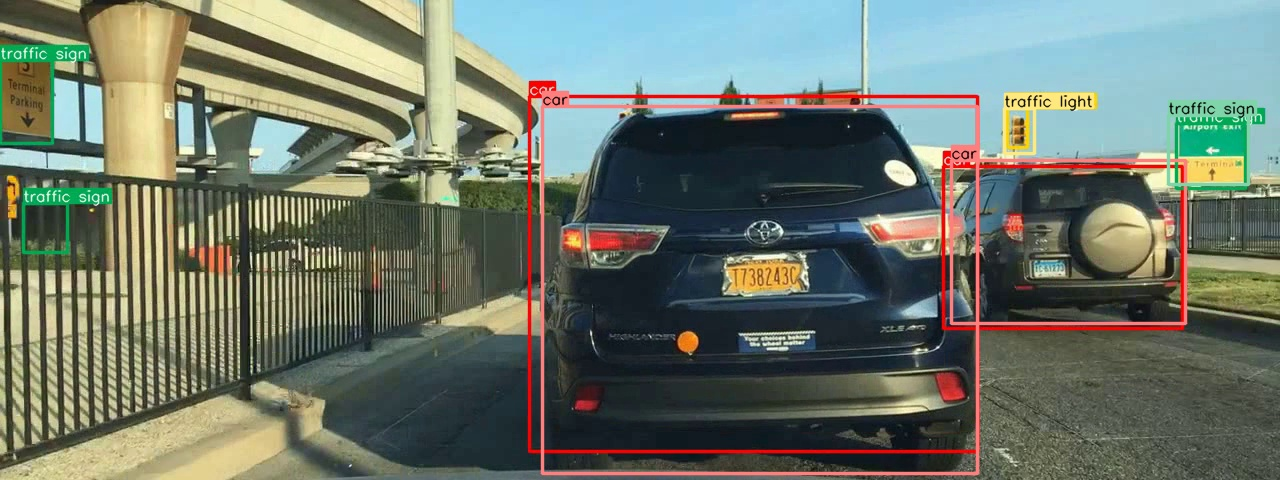

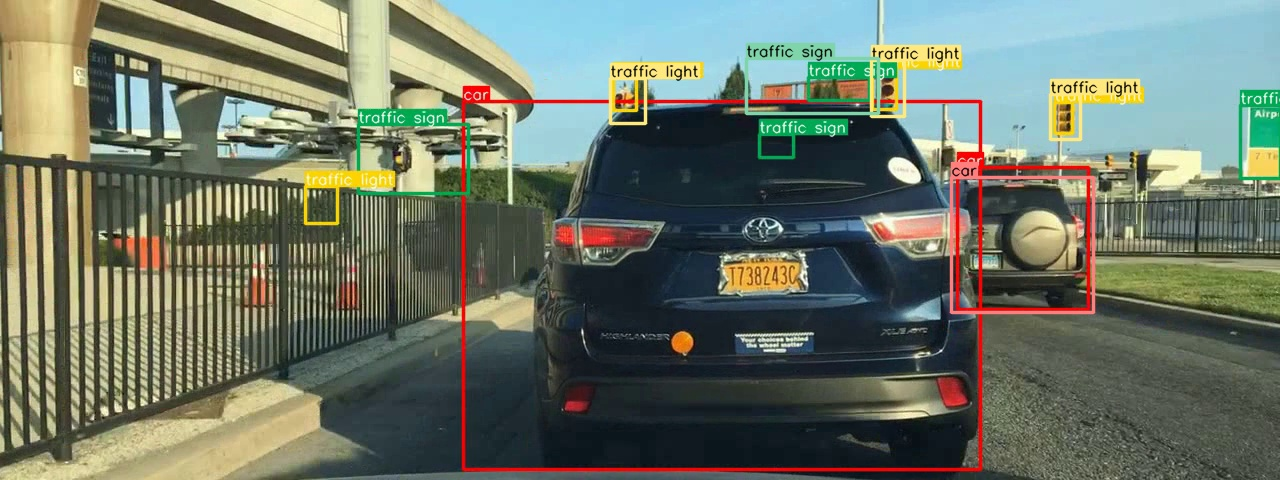

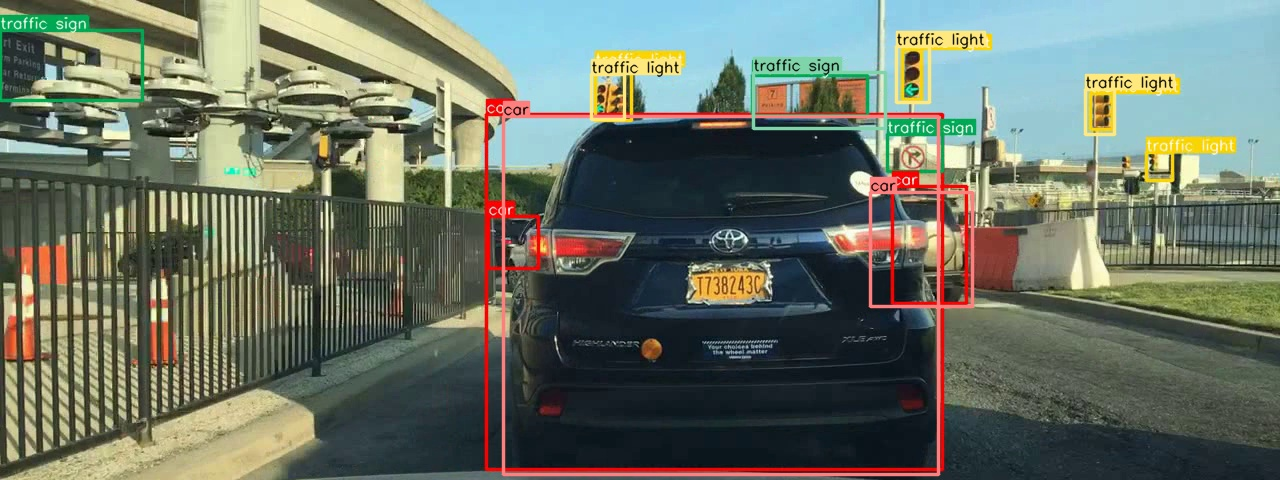

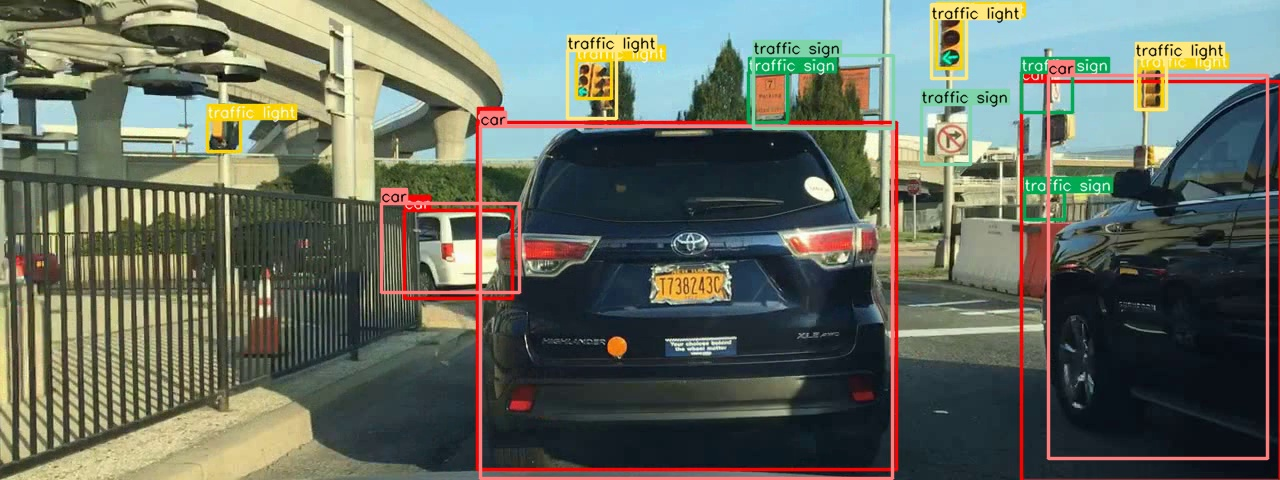

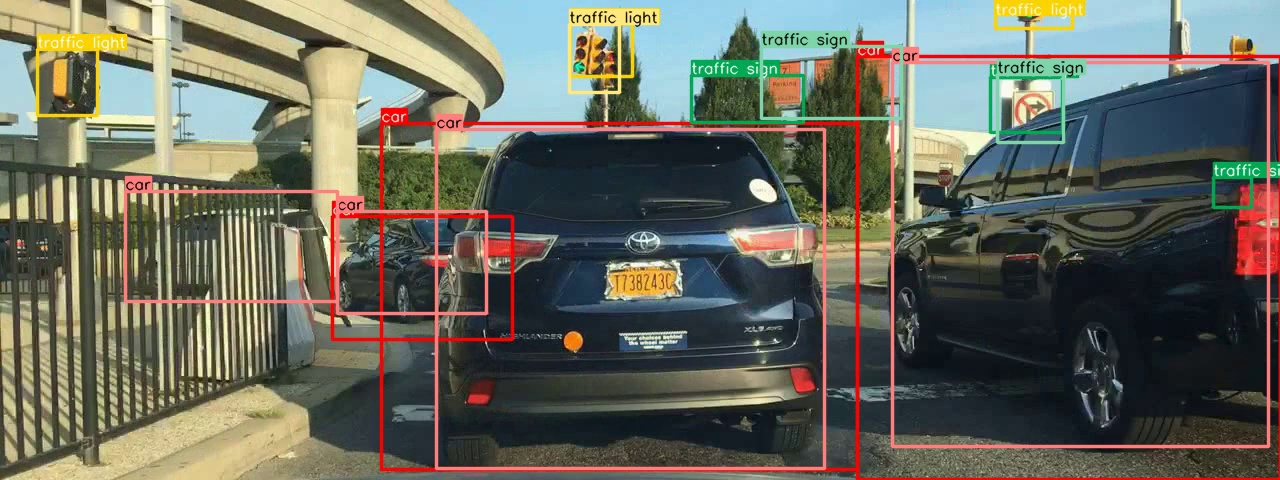

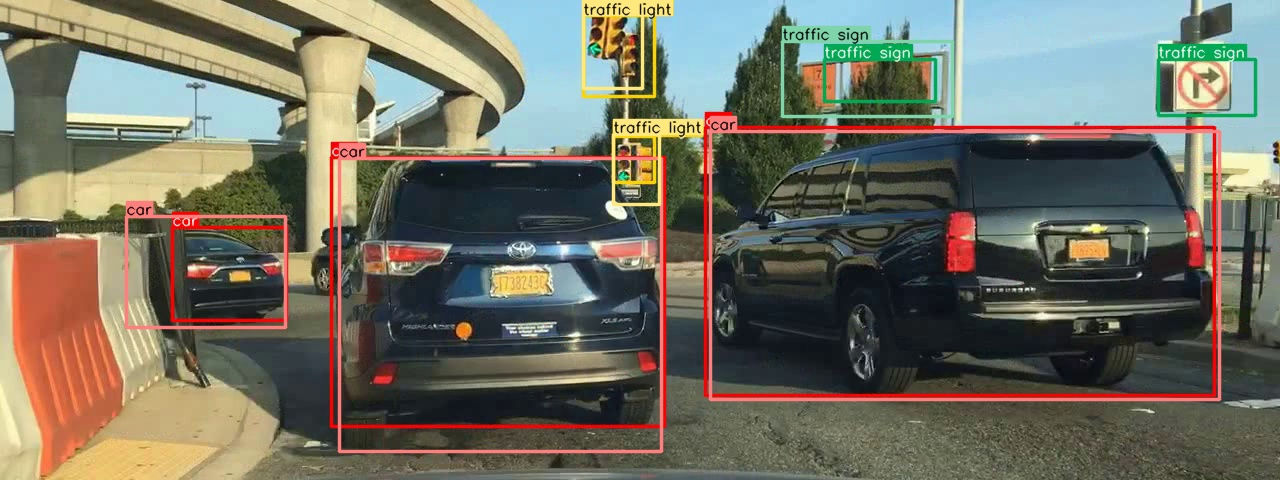

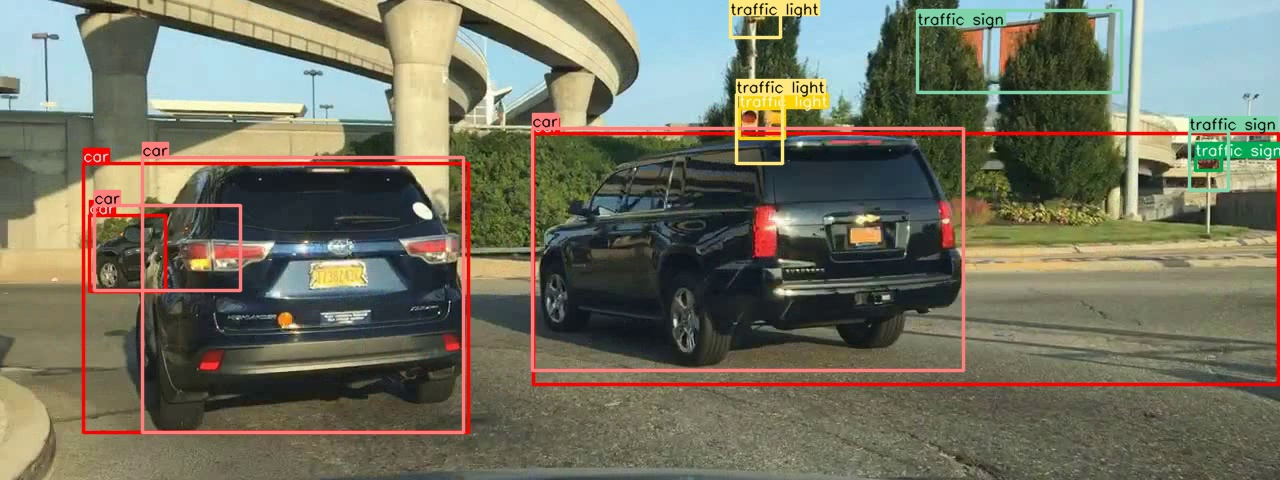

No more frames to read.
Finished processing 0000f77c-6257be58.mp4.


In [8]:
for video_path, detections_json in gt.items():
    video_name = video_path.split("/")[-1]
    video_path = f"{config.paths.tmp}/{video_name}"

    detections_by_timestamp = {
        ts_data['timestamp']: [
            Detection(
                box_2d=obj['box_2d'],
                label=obj['label'],
                confidence=obj['confidence']
            )
            for obj in ts_data['objects']
        ]
        for ts_data in detections_json
    }

    cap = ocv.init_video_capture(video_path)
    (
        fps,
        width,
        height,
        total_frames,
        _,
    ) = ocv.get_video_properties(cap)


    frame_count = 0
    timestamps = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("No more frames to read.")
            break

        current_second = int(frame_count / fps)
        minutes = current_second // 60
        seconds = current_second % 60
        timestamp_str = f"{minutes:02d}:{seconds:02d}"
        detections_for_frame = detections_by_timestamp.get(timestamp_str, [])

        frame_with_boxes = ocv.get_frame_with_boxes(
            frame,
            detections_for_frame,
            width,
            height,
            inverse_colors=True,
        )
        display(Image(frame_with_boxes))
        frame_count += 1

        if current_second >= len(detections_json):
            print(f"Reached end of annotated data for {video_name}.")
            break

    cap.release()
    print(f"Finished processing {video_name}.")